In [1]:
import random
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import precision_score, roc_auc_score, make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
import os
http://localhost:8888/?token=876b2b5a7b00ac560ebc82404e95ef33f1c97829dcd308df
os.environ['PYTHONHASHSEED']=str(271828)
random.seed(271828)
np.random.seed(271828)
#import tensorflow as tf
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from tensorflow.python.framework import ops
import tensorflow as tf
tf.random.set_seed(271828)
ops.reset_default_graph()

from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
#from tensorflow.keras.layers import Conv2D, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

import keras.backend as K
#session_conf=tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1) 
#sesCriticalSection=tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

Using TensorFlow backend.


In [2]:
def PCL_calculator(df):

    symptomatic_cutoff = 2

    intrusion = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH', 'q6.4_UPSET', 'q6.5_PHYS']
    avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES', 'q6.9_DISINT', 'q6.10_DTACH',
                 'q6.11_NUMB', 'q6.12_FUTRE']
    tred = ['q6.1_INTRU', 'q6.2_DREAM', 'q6.3_FLASH']
    only_avoidance = ['q6.6_AVTHT', 'q6.7_AVSIT', 'q6.8_AMNES']

    hypertension = ['q6.13_SLEEP', 'q6.14_ANGER', 'q6.15_CONC', 'q6.16_HYPER', 'q6.17_STRTL']

    depression = ['q6.9_DISINT', 'q6.10_DTACH', 'q6.11_NUMB', 'q6.12_FUTRE']

    df[intrusion + avoidance + hypertension].fillna(df[intrusion + avoidance + hypertension].mean(axis=1))
    intrusion_cuoff = 1
    avoidance_cuoff = 3
    hypertension_cuoff = 2
    only_avoidance_cutoff = 1
    depression_cutoff = 2
    tred_cutoff = 1

    df['sum'] = (df[intrusion + avoidance + hypertension]).sum(axis=1)

    df['intrusion'] = (df[intrusion] > symptomatic_cutoff).sum(axis=1)
    df['intrusion_cutoff'] = (df['intrusion'] >= intrusion_cuoff).astype(int)

    df['avoidance'] = (df[avoidance] > symptomatic_cutoff).sum(axis=1)
    df['avoidance_cutoff'] = (df['avoidance'] >= avoidance_cuoff).astype(int)

    df['depression'] = (df[depression] > symptomatic_cutoff).sum(axis=1)
    df['depression_cutoff'] = df['depression'] >= depression_cutoff

    df['hypertention'] = (df[hypertension] > symptomatic_cutoff).sum(axis=1)
    df['hypertention_cutoff'] = (df['hypertention'] >= hypertension_cuoff).astype(int)

    df['tred'] = (df[tred] > symptomatic_cutoff).sum(axis=1)
    df['tred_cutoff'] = df['tred'] >= tred_cutoff

    df['only_avoidance'] = (df[only_avoidance] > symptomatic_cutoff).sum(axis=1)
    df['only_avoidance_cutoff'] = df['only_avoidance'] >= only_avoidance_cutoff

    df['regression_cutoff_33'] = df['sum'] >= 33
    df['regression_cutoff_50'] = df['sum'] >= 50
    df['diagnosis'] = ((df['hypertention_cutoff']) & (df['avoidance_cutoff']) & (df['intrusion_cutoff']) & (df['sum'] >= 50))

    return df



In [3]:
path = "C:\‏‏PycharmProjects\PTSD\Data\PTSD.xlsx"
df = pd.read_excel(path)
#combine with specifics of answers
df_pcl2 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL2.xlsx")
df_pcl1 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL1.xlsx")
df = df.merge(df_pcl1, on="ID", how='outer')
df = df.merge(df_pcl2, suffixes=('_pcl1', '_pcl2'), on="ID", how='outer')

df_pcl3 = pd.read_excel("C:\‏‏PycharmProjects\PTSD\Data\questionnaire6PCL3.xlsx")
df_pcl3 = PCL_calculator(df_pcl3)
df = df.merge(df_pcl3.drop(['PCL3_Strict', 'pcl3', 'PCL3_Broad'], axis=1), on="ID", how='outer')
# rmoving missing Y's
df = df[~df['PCL_Strict3'].isna()]

## features 

In [4]:
# removed age
features = ["highschool_diploma", "dyslexia", "ADHD", "T1Acc1t", "T1Acc1n", "T1bias", "phq1", "lot1",
                "trait1",
                "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2", "trait2", "state2", "PCL2", "PCL_Broad2",
                "PCL_Strict2", "cd_risc1", "active_coping1", "planning1", "positive_reframing1", "acceptance1",
                "humor1",
                "religion1", "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2", "planning2",
                "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                "instrumental_support2",
                "self_distraction2", "denial2", "venting2", "substance_use2", "behavioral_disengagement2",
                "self_blame2",
                "trauma_history8_1", "HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5", 'q6.1_INTRU_pcl1', 
                'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                  'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                  'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                  'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                  'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                  'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                  'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                  'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2']

In [5]:
t2_features = [
    "lot2", "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2",
    "active_coping2", "planning2", "positive_reframing2", "acceptance2", "humor2", 
    "religion2", "emotional_support2", "instrumental_support2", "self_distraction2",
    "denial2", "venting2", "substance_use2", "behavioral_disengagement2", "self_blame2",
    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2', 'q6.5_PHYS_pcl2',
    'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2'
]
t1_features =[ "active_coping1","T1Acc1t", "T1Acc1n", "T1bias", "phq1", "lot1",
                "trait1","state1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1",
              "PCL1", "PCL_Broad1", "PCL_Strict1","cd_risc1", 
                'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1','q6.13_SLEEP_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1']

In [6]:
discrete_features = ["highschool_diploma", "dyslexia", "ADHD", "phq1", "lot1",
                    "trait1", "state1", "PCL1", "PCL_Broad1", "PCL_Strict1", "phq2", "lot2",
                    "trait2", "state2", "PCL2", "PCL_Broad2", "PCL_Strict2", "cd_risc1", "active_coping1",
                    "planning1", "positive_reframing1", "acceptance1", "humor1", "religion1",
                    "emotional_support1", "instrumental_support1", "self_distraction1", "denial1",
                    "venting1", "substance_use1", "behavioral_disengagement1", "self_blame1", "active_coping2",
                    "planning2", "positive_reframing2", "acceptance2", "humor2", "religion2", "emotional_support2",
                    "instrumental_support2", "self_distraction2", "denial2", "venting2", "substance_use2",
                    "behavioral_disengagement2", "self_blame2", "trauma_history8_1",
                    'q6.1_INTRU_pcl1', 'q6.2_DREAM_pcl1', 'q6.3_FLASH_pcl1', 'q6.4_UPSET_pcl1',
                    'q6.5_PHYS_pcl1', 'q6.6_AVTHT_pcl1', 'q6.7_AVSIT_pcl1', 'q6.8_AMNES_pcl1', 'q6.9_DISINT_pcl1',
                    'q6.10_DTACH_pcl1', 'q6.11_NUMB_pcl1', 'q6.12_FUTRE_pcl1', 'q6.13_SLEEP_pcl1',
                    'q6.14_ANGER_pcl1', 'q6.15_CONC_pcl1', 'q6.16_HYPER_pcl1', 'q6.17_STRTL_pcl1',
                    'q6.1_INTRU_pcl2', 'q6.2_DREAM_pcl2', 'q6.3_FLASH_pcl2', 'q6.4_UPSET_pcl2',
                    'q6.5_PHYS_pcl2', 'q6.6_AVTHT_pcl2', 'q6.7_AVSIT_pcl2', 'q6.8_AMNES_pcl2', 'q6.9_DISINT_pcl2',
                    'q6.10_DTACH_pcl2', 'q6.11_NUMB_pcl2', 'q6.12_FUTRE_pcl2', 'q6.13_SLEEP_pcl2',
                    'q6.14_ANGER_pcl2', 'q6.15_CONC_pcl2', 'q6.16_HYPER_pcl2', 'q6.17_STRTL_pcl2']

In [7]:
genome_features = ["HML_5HTT", "HL_MAOA", "HML_NPY", "COMT_Hap1_recode",
                "COMT_Hap2_recode", "COMT_Hap1_LvsMH", "HML_FKBP5"]
continuous_features = ["T1Acc1t", "T1Acc1n", "T1bias"]
demographic_features = ["highschool_diploma", "dyslexia", "ADHD"]

In [38]:
df1 = df[features + ['PCL_Strict3']]
#df1 = df1.dropna(thresh=47)
df_t1 = df1[t1_features]
df_t2 = df1[t2_features]
df1 = df1[df_t2.isna().astype(int).sum(axis=1)<36]
df1 = df1[df_t1.isna().astype(int).sum(axis=1)<42]

In [40]:
df1.shape

(534, 92)

In [43]:
sum(df1.isna().sum(axis=1)>40)

2

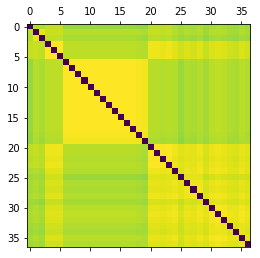

In [37]:
import matplotlib.pyplot as plt
plt.matshow(d.corr()-np.eye(d.shape[1]))
plt.show()                              

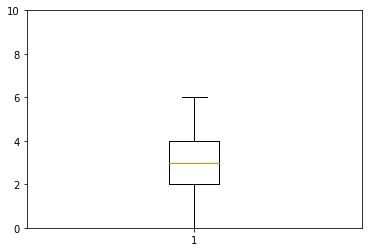

In [30]:
import matplotlib.pyplot as plt
plt.boxplot(df1['self_blame2'])
plt.ylim(0,10)
plt.show()

In [31]:
from scipy import stats
df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

AttributeError: 'float' object has no attribute 'sqrt'

## fill the missing values

In [29]:
df1[genome_features] = df1[genome_features].fillna(0)
df1[continuous_features] = df1[continuous_features].fillna(df1[continuous_features].mean())
df1[discrete_features] = df1[discrete_features].fillna(df1[discrete_features].median())


## cut off the test set

In [13]:
X, X_out, Y, y_out = train_test_split(df1[features], df1['PCL_Strict3'],
                                      test_size=0.25, random_state=271828, stratify=df1['PCL_Strict3'])


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=271828)
cv = StratifiedKFold(5, random_state=271828)  

## the Model

In [15]:
def roc_auc(y_true, y_pred):
    ptas = tf.stack([binary_PTA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.stack([binary_PFA(y_true,y_pred,k) for k in np.linspace(0, 1, 1000)],axis=0)
    pfas = tf.concat([tf.ones((1,)) ,pfas],axis=0)
    binSizes = -(pfas[1:]-pfas[:-1])
    s = ptas*binSizes
    return K.sum(s, axis=0)

#---------------------
# PFA, prob false alert for binary classifier
def binary_PFA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # N = total number of negative labels
    N = K.sum(1 - y_true)
    # FP = total number of false alerts, alerts from the negative class labels
    FP = K.sum(y_pred - y_pred * y_true)
    return FP/N

#----------------
# P_TA prob true alerts for binary classifier
def binary_PTA(y_true, y_pred, threshold=K.variable(value=0.5)):
    y_pred = K.cast(y_pred >= threshold, 'float32')
    # P = total number of positive labels
    P = K.sum(y_true)
    # TP = total number of correct alerts, alerts from the positive class labels
    TP = K.sum(y_pred * y_true)
    return TP/P

In [16]:
def create_model(dropout_rate=0.0, activation='relu', number_of_neurons=30, second_layer=0):
    visible = Input(shape=(92,))
    x = Dense(number_of_neurons, activation=activation)(visible)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    if second_layer>0:
        x = Dense(second_layer, activation=activation)(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)
    
    
    output_diagnosis = Dense(1, activation='sigmoid')(x)
    
    
    model = Model(inputs=visible, outputs=output_diagnosis)
   
    model.compile(loss='binary_crossentropy', optimizer='adam')#, random_state=271828)#,metrics=[roc_auc])
        
    return model


In [17]:
ss= StandardScaler()
X_train = ss.fit_transform(X_train)

In [18]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.9]
number_of_neurons = [60]
second_layer = [15]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)






## iterate epochs

In [21]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'elu']
dropout_rate = [0.8]
number_of_neurons = [60]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.8619678068410462 
params =  {'activation': 'tanh', 'dropout_rate': 0.8, 'number_of_neurons': 60, 'second_layer': 30}


In [ ]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [60]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [17]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.5]
number_of_neurons = [60]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7868700201207244 
params =  {'activation': 'tanh', 'dropout_rate': 0.5, 'number_of_neurons': 60, 'second_layer': 30}


In [ ]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.4]
number_of_neurons = [60]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.25]
number_of_neurons = [60]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [18]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh', 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [20]
second_layer = [10]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.8573754527162978 
params =  {'activation': 'elu', 'dropout_rate': 0.75, 'number_of_neurons': 20, 'second_layer': 10}


In [ ]:
from sklearn.metrics import roc_curve, auc

probs = scores_auc.best_estimator_.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

In [ ]:
plt.hist(preds[y_test==0], bins=30, color="b", label="non PTSD")
plt.hist(preds[y_test==1], bins=20, alpha=0.8, color="r", label="PTSD")
plt.xlabel('pred probability')
plt.legend();
preds[y_test==1]

In [15]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [100]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7031453158247417 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 100, 'second_layer': 30}


In [16]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [80]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6837622871115694 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 80, 'second_layer': 30}


In [17]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.25]
number_of_neurons = [60]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6403015580049074 
params =  {'activation': 'tanh', 'dropout_rate': 0.25, 'number_of_neurons': 60, 'second_layer': 30}


In [18]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [40]
second_layer = [30]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7361066839535739 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 40, 'second_layer': 30}


In [14]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [60]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7455333945764567 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 60, 'second_layer': 5}


In [15]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [60]
second_layer = [15]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7298370451480499 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 60, 'second_layer': 15}


In [16]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [60]
second_layer = [25]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7167496863669113 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 60, 'second_layer': 25}


In [17]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [60]
second_layer = [45]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7083595184073654 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 60, 'second_layer': 45}


In [18]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.9]
number_of_neurons = [60]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.73819404441414 
params =  {'activation': 'tanh', 'dropout_rate': 0.9, 'number_of_neurons': 60, 'second_layer': 5}


In [13]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [30]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7381978231260529 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 30, 'second_layer': 5}


In [14]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [15]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7078408272188177 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 15, 'second_layer': 5}


In [15]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.765946248242899 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [16]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.5]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7109857231866802 
params =  {'activation': 'tanh', 'dropout_rate': 0.5, 'number_of_neurons': 90, 'second_layer': 5}


In [13]:
model = KerasClassifier(build_fn=create_model)
activation = ['relu']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7099617762297188 
params =  {'activation': 'relu', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [14]:
model = KerasClassifier(build_fn=create_model)
activation = ['elu']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7078252925142877 
params =  {'activation': 'elu', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [16]:
model = KerasClassifier(build_fn=create_model)
activation = ['sigmoid']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6832427562092633 
params =  {'activation': 'sigmoid', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [13]:
model = KerasClassifier(build_fn=create_model)
activation = ['elu']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6999974808587249 
params =  {'activation': 'elu', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [ ]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [190]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [14]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [2]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.771714409991922 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 2}


In [15]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7774699760345694 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [15]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [150]
second_layer = [10]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6743368360593242 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 150, 'second_layer': 10}


In [ ]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.7]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [16]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [10]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6989378460670327 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 10}


In [17]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [90]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7036476325950011 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 90, 'second_layer': 5}


In [ ]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [150]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [18]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.75]
number_of_neurons = [150]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.7366253751421216 
params =  {'activation': 'tanh', 'dropout_rate': 0.75, 'number_of_neurons': 150, 'second_layer': 5}


In [15]:
model = KerasClassifier(build_fn=create_model)
activation = ['tanh']#, 'relu', 'elu']
dropout_rate = [0.5]
number_of_neurons = [60]
second_layer = [5]
param_grid = dict(activation=activation, dropout_rate=dropout_rate, 
                  number_of_neurons=number_of_neurons, second_layer=second_layer)

scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

roc_auc 0.6497454827598369 
params =  {'activation': 'tanh', 'dropout_rate': 0.5, 'number_of_neurons': 60, 'second_layer': 5}


## CV model of roc auc 

In [ ]:
my_callbacks = [EarlyStopping(monitor='roc_auc', patience=30, verbose=1, mode='max')]

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0,
                                                                                  'validation_split' :0.2,
                                                                                   'callbacks':my_callbacks})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
my_callbacks = [EarlyStopping(monitor='roc_auc', patience=3, verbose=1, mode='max')]
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0,
                                                                                  'validation_split' :0.1,
                                                                                   'callbacks':my_callbacks})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
my_callbacks = [EarlyStopping(monitor='roc_auc', patience=5, verbose=1)]#, mode='max')]
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0,
                                                                                  'validation_split' :0.2,
                                                                                   'callbacks':my_callbacks})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
my_callbacks = [EarlyStopping(monitor='roc_auc', patience=25, verbose=1)]#, mode='max')]
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 500,
                                                                                   'verbose':0,
                                                                                  'validation_split' :0.15,
                                                                                   'callbacks':my_callbacks})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
my_callbacks = [EarlyStopping(monitor='roc_auc', patience=100, verbose=1, mode="max")]#, mode='max')]
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 1000,
                                                                                   'verbose':0,
                                                                                  'validation_split' :0.15,
                                                                                   'callbacks':my_callbacks})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 1000,
                                                                                   'verbose':0,
                                                                                  'callbacks': [EarlyStopping(monitor='loss', patience=30, verbose=0)]})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 500,
                                                                                   'verbose':0,
                                                                                  'callbacks': [EarlyStopping(monitor='loss', patience=30, verbose=0)]})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 500,
                                                                                   'verbose':0,
                                                                                  'callbacks': [EarlyStopping(monitor='loss', patience=10, verbose=0)]})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0,
                                                                                  'callbacks': [EarlyStopping(monitor='loss', patience=10, verbose=0)]})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 300,
                                                                                   'verbose':0,
                                                                                  'callbacks': [EarlyStopping(monitor='loss', patience=50, verbose=0)]})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

In [ ]:
scores_auc = GridSearchCV(model, param_grid, cv=cv, scoring="roc_auc", fit_params={'epochs': 200,
                                                                                   'verbose':0})
scores_auc.fit(X_train, y_train)
print("roc_auc", scores_auc.best_score_,"\nparams = ", scores_auc.best_params_)

## CV model of precision

In [ ]:
scores_f1 = GridSearchCV(model, param_grid, cv=cv, scoring="f1", fit_params={'callbacks':
                                                                             #[EarlyStopping(monitor='loss',patience=300,verbose=0)],
                                                                            EarlyStopping(monitor='loss',patience=100,verbose=0),
                                                                       #     EarlyStopping(monitor='loss',patience=20,verbose=0)]
                                                                             'verbose':[0]})
scores_f1.fit(X_train, y_train)
#scores = cross_val_score(model, X_train, y_train, scoring="roc_auc", cv=cv)
print("f1", scores_f1.best_score_,"\nparams = ", scores_f1.best_params_)

## CV model of f1

In [ ]:
scores = cross_val_score(scores_auc.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())

scores = cross_val_score(scores_f1.best_estimator_, X_train, y_train, scoring="precision", cv=cv)
print("precision\n", scores,"\nmean = ", scores.mean())

## predict holdout set

In [ ]:
y_pred1 = scores_f1.best_estimator_.predict_proba(X_test)
y_pred2 = scores_auc.best_estimator_.predict_proba(X_test)
y_pred = y_pred1[:, 1]>0.25
print("f1 precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))
y_pred = y_pred2[:, 1]>0.25
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


In [ ]:
y_pred = y_pred1[:, 1]>0.15
print("f1 precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))
y_pred = y_pred2[:, 1]>0.15
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


In [ ]:
y_pred = y_pred1[:, 1]>0.6
print("f1 precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))
y_pred = y_pred2[:, 1]>0.6
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


In [ ]:
y_pred = y_pred1[:, 1]>0.5
print("f1 precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))
y_pred = y_pred2[:, 1]>1e-08
print("auc precision_score =", precision_score(y_test, y_pred), "from ", sum(y_pred))


In [ ]:
max(y_pred2[:,1])